# Settings

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split

import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2
import random
from time import time

Using TensorFlow backend.


# Prepare data

In [2]:
def prepare_data():
    """ Divides data into images and labels.
        Substracts mean per-channel image from all images.
        Then normalizes pixel values between 0 and 1.
    Returns:
        normalized_X : array with images
        y : array with corresponding labels
        (0 for non-IDC, 1 for IDC)
    """
    patches = glob.glob('./padded/*.png')
    X = []
    y = []

    for img_name in patches[:10000]:
        image = cv2.imread(img_name)
        X.append(image)
        y.append(0) if img_name.endswith('class0.png') else y.append(1)
    
    mean_image = np.sum(np.array(X), axis=0) / len(X)  # per channel mean image of shape (50, 50, 3)
    centered_X = np.array(X) - mean_image              # has negative pixel values, so we normalize in the next step
    normalized_X = centered_X - np.min(centered_X)/(np.max(centered_X) - np.min(centered_X))
    
    return normalized_X, y

# Build a ConvNet

In [3]:
def create_CNN():
    input_shape = (50, 50, 3)
    num_classes = 2
    reg = 0.0001
    
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [4]:
cnn_pad = create_CNN()
cnn_pad.summary()
plot_model(cnn_pad, to_file='simple_cnn_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
__________

# Analyze the training set

In [5]:
X, y = prepare_data()

print(X.shape)
print(y.count(1))
print(y.count(0))

(10000, 50, 50, 3)
2797
7203


In [6]:
def balance(X, y):
    """ Function for getting perfectly balanced data set (50/50)
        Takes as many negative examples, as there are positive ones
        DON'T USE IT IF YOUR DATASET IS OK
    """
    X0 = []
    X1 = []
    for i in range(0, len(y)):
        X1.append(X[i]) if y[i] == 1 else X0.append(X[i]) 
    X0 = np.array(X0)
    X1 = np.array(X1)
    
    X0 = X0[:len(X1)]
    X_balanced = np.concatenate((X0, X1))

    a = [0] * len(X0) 
    b = [1] * len(X1)
    y_balanced = a + b

    return X_balanced, y_balanced
    
#X, y = balance(X, y)
#print(X.shape)
#print(y.count(1))
#print(y.count(0))

# Train and evaluate the network

In [7]:
X_train_tune, X_test, y_train_tune, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

y_train_tune_onehot = np_utils.to_categorical(y_train_tune, 2)
y_test_onehot = np_utils.to_categorical(y_test, 2)

epochs = 20
batch_size = 128

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}{}".format(time(),'_centered_bn_act'), histogram_freq=1, 
                          batch_size=batch_size, 
                          write_grads=True, write_images=False)

fit_history = cnn_pad.fit(X_train_tune, y_train_tune_onehot,
                          batch_size=batch_size,
                          epochs=epochs, shuffle=True, 
                          verbose=1, validation_split=0.1, callbacks=[tensorboard, early_stopping])

Train on 8100 samples, validate on 900 samples
Epoch 1/20
8100/8100 [==============================] - 264s 33ms/step - loss: 0.6781 - acc: 0.7894 - val_loss: 0.7095 - val_acc: 0.8411
Epoch 2/20
8100/8100 [==============================] - 286s 35ms/step - loss: 0.5354 - acc: 0.8206 - val_loss: 0.5150 - val_acc: 0.8478
Epoch 3/20
8100/8100 [==============================] - 294s 36ms/step - loss: 0.5053 - acc: 0.8328 - val_loss: 0.4887 - val_acc: 0.8344
Epoch 4/20
8100/8100 [==============================] - 292s 36ms/step - loss: 0.4864 - acc: 0.8395 - val_loss: 0.4595 - val_acc: 0.8500
Epoch 5/20
8100/8100 [==============================] - 257s 32ms/step - loss: 0.4755 - acc: 0.8367 - val_loss: 0.4695 - val_acc: 0.8356
Epoch 6/20
8100/8100 [==============================] - 292s 36ms/step - loss: 0.4588 - acc: 0.8442 - val_loss: 0.4676 - val_acc: 0.8278
Epoch 7/20
8100/8100 [==============================] - 281s 35ms/step - loss: 0.4480 - acc: 0.8501 - val_loss: 0.4624 - val_acc: 0

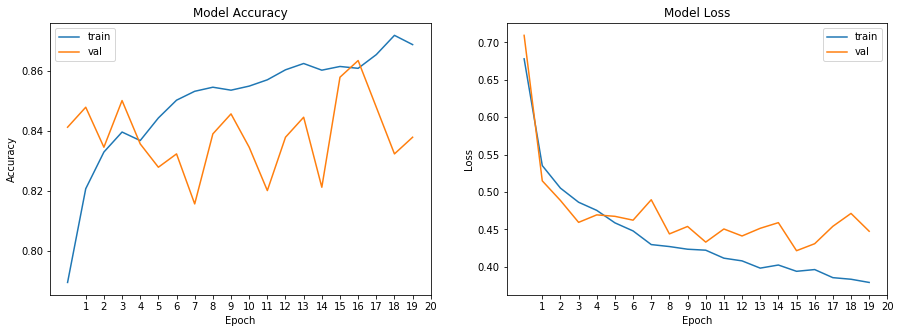

In [8]:
def plot_history(history):
    """ Util function for plotting model's accuracy and loss
        Could be deleted since all the info is in Tensorboard
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set_xticks(np.arange(1, len(history.history['acc'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_xticks(np.arange(1, len(history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_history(fit_history)

# Evaluate the performance on the test set

In [9]:
#score_pad = cnn_pad.evaluate(X_test, y_test_onehot, verbose=0)
#print('Test loss:', score_pad[0])
#print('Test accuracy:', score_pad[1])

#plt.plot(fit_history.history['loss'])
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Simple CNN with padded imgs')
#plt.show()